In [1]:
from IPython.display import Image

## 6.1 DB-Derived potentials

Semi-empirical based on approximations of quantum-chemistry, such as force-fields, have a low accuracy predicting the folding of proteins. This was proved in “An analysis of incorrectly Folded protein Models” by Karplus, where it was possible to minimize the incoherences between two unrelated proteins, resulting in a false positive for homology.

This is because force-fields calculations sometimes fail to capture some interactions between side-chains or more distant atoms that result in unfeasible folding predictions.

## Boltzmann distribution

The Bolzmann distribution relates potential energy and temperature to probability

$p(x) \propto e^{\frac {-U(x)}{b_B \cdot T}}$

where T is temperature and $k_b$ is the Boltzmann constant

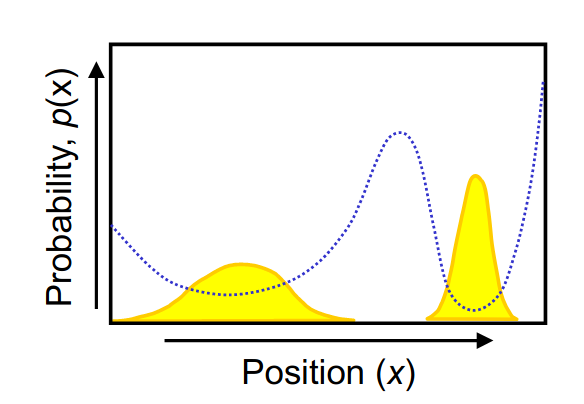

In [2]:
Image(filename='images/boltzmann.png') 

Key properties:
- Higher energies gives lower probability
- Exponential relationship: Constant energy increase to halve probability
- Temperature dependence: At higher temperature the energy increase has to be bigger

Sometimes it's difficult to predict the overall energy of a macro/microstate, but the probability ratio between two states can be efficiently calculated:

$\frac {N_1}{N_2} = e^{\frac{-\Delta E}{k_b T}}$

We can estimate the difference in energy between two states from their counts using the inverse Boltzmann law:

$\Delta E = -k_b \cdot \ln (\frac{N_1}{N_2})$

Using this and taking into account different relationships (i.e. distances between $C\alpha$ that are 4 positions away in the chain), the relative frequencies of the different distances  can be used to create Boltmann distributions of the different distances for particular cases. This are the so-called DB-derived Mean Force potentials.

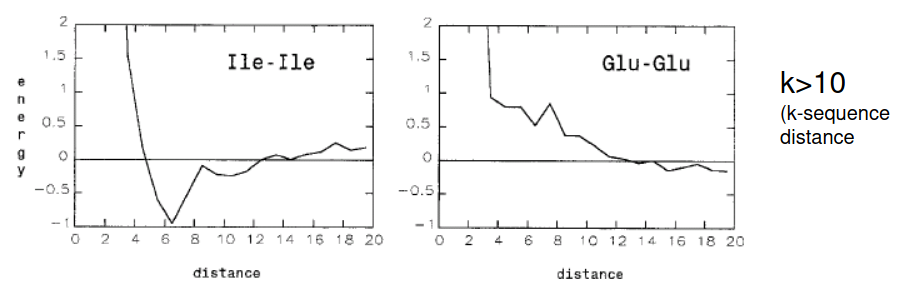

In [4]:
Image(filename='images/db-mean.png') 

### Db-derived solvation energies

DB-info can be used to derive estimations of solvation energies. For that, we define a $\delta$-neighborhood in the euclidean space of the different types of aminoacids and count the number of number on neighboring aminoacids, relative to the overall aa-types:

$E_{aa,r} = -k_b \cdot \ln (\frac{f_{aa,N_r}}{f_{x,N_r}})$

leading to estimations of the position of the different aminoacids to the water accesible area:

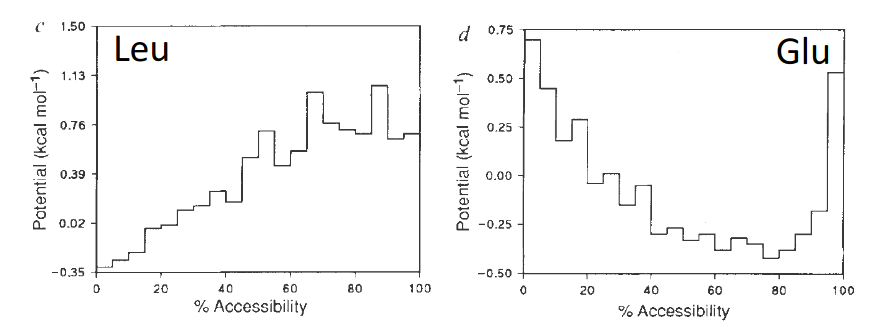

In [6]:
Image(filename='images/water.png') 

### Applications

Mean force potentials failed to be a good folding-prediction tool, but are a powerful tool for:
- evaluating the correctness of a model.
- Solving the reverse folding problem (finding a sequence compatible with an observed fold).



### Weaknesses

- Lack of detail leads to implausible structures (i.e impossible in nature bond angles).
- Fails to capture interactions at a global level (multibody effect).

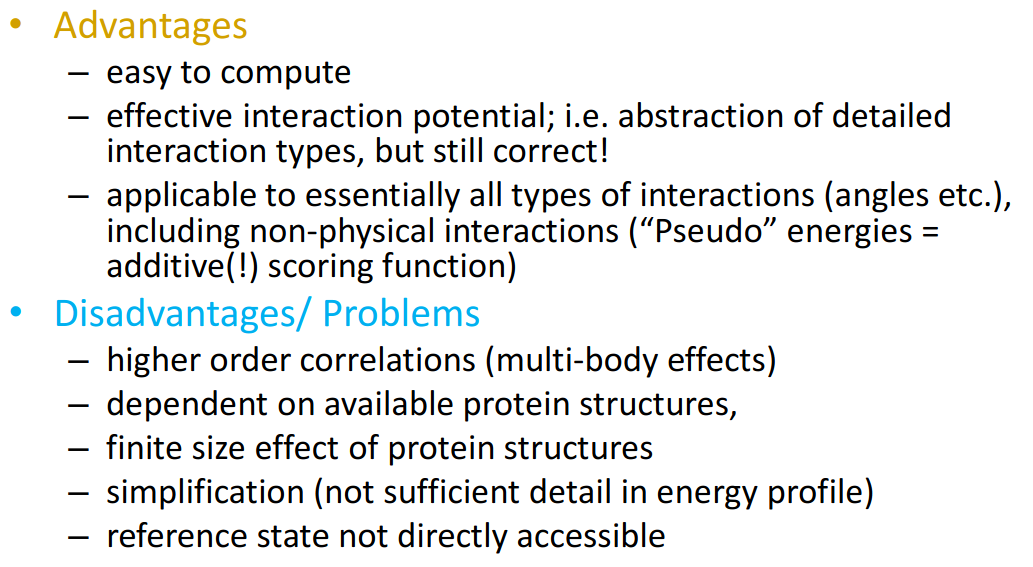

In [7]:
Image(filename='images/summary.png') 

###  Procedure for finding the inverse Bolzmann distribution of a protein

In [31]:
import numpy as np
from numpy import linalg as la
from CifFile import ReadCif
import urllib
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
url = "https://files.rcsb.org/view/3BY8.cif"
file = urllib.request.urlopen(url)
cf = ReadCif(file)
cf = cf['3by8']
columns = [
'_atom_site.group_PDB',
'_atom_site.id',
'_atom_site.type_symbol',
'_atom_site.label_atom_id',
'_atom_site.label_alt_id',
'_atom_site.label_comp_id',
'_atom_site.label_asym_id',
'_atom_site.label_entity_id',
'_atom_site.label_seq_id',
'_atom_site.pdbx_PDB_ins_code',
'_atom_site.Cartn_x',
'_atom_site.Cartn_y',
'_atom_site.Cartn_z',
'_atom_site.occupancy',
'_atom_site.B_iso_or_equiv',
'_atom_site.pdbx_formal_charge',
'_atom_site.auth_seq_id',
'_atom_site.auth_comp_id',
'_atom_site.auth_asym_id',
'_atom_site.auth_atom_id',
'_atom_site.pdbx_PDB_model_num'
  ]
subscolumns = [re.sub("^_atom_site.", "", column) for column in columns]
zipped = zip(columns, subscolumns)
dict = {tuple[1]:cf[tuple[0]] for tuple in zipped}
df = pd.DataFrame(dict)
df
coordinate_columns = ["Cartn_x", "Cartn_y","Cartn_z"]
types = {column:float for column in coordinate_columns}
df = df.astype(types)

#### Obtain pairwise distances:
We choose a reference pairwise atom distances,such as the center of mass, alpha carbon (in the example)... 

In [12]:
dfca = df[df.loc[:,"label_atom_id"] == "CA"]

And a distance in the linear sequence (4 in the example)

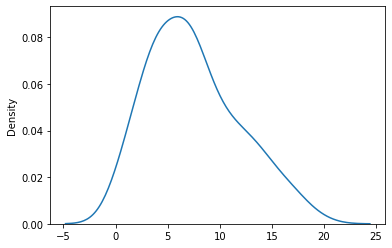

In [36]:
def get_distances(df, step=4, reference_atom="CA"):
    distances = []
    df = df[df.loc[:,"label_atom_id"] == reference_atom]
    for n in np.arange(0, df.shape[0]-step):
        xyz1 = df.iloc[n].loc[['Cartn_x', 'Cartn_x', 'Cartn_x']].to_numpy()
        xyz2 = df.iloc[n+step].loc[['Cartn_x', 'Cartn_x', 'Cartn_x']].to_numpy()
        distances.append(euclidean(xyz1, xyz2))
    return np.array(distances)
sns.kdeplot(get_distances(df, 4))
plt.show()